# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors

import package_DBR
import package_LAB

from importlib import reload
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode
from package_LAB import LL_RT, PID_RT,IMC_Tuning, FF_RT
package_LAB=reload(package_LAB)

# Paramètres

In [2]:
TSim = 4000
Ts = 1
N = int(TSim / Ts) + 1

# DV MV PV 
DV0 = 50
MV0 = 50
PV0 = 60


# paramètres de ^P(s) 2eme ordre pouvant être considérer comme premier ordre 

Kp = 0.57353288531197
T1p = 184.504684095101
T2p= 1.78243605751087E-07
thetap=6.19336906382859

# paramètres de ^D(s) 2ème ordre 
Kd = 0.553358040201031
T1d= 172.259419274141
T2d= 22.1508608750117
thetad =0.533716544751782

#rapport des gains 
KFF = -Kd/Kp

#Coef PID
alpha= 0.2
gamma = 0.9
Kc,T_I,T_D = IMC_Tuning(Kp,T1p,T2p,thetap,gamma,'SOPDT')
print('Kc : ',Kc,'T_I : ',T_I,'T_D',T_D )

#limites
MV_MIN = 0
MV_MAX = 100

Kc :  1.9373102059878127 T_I :  184.5046842733446 T_D 1.78243605578892e-07


# Vectors

In [3]:
t = []
SP = []
DV = []
PV = []
E = []
MV = []
MV_P = []
MV_I = []
MV_D = []
MAN = []
MV_MAN = []

MVFFDelay = []
MVFFLL1 = []
MV_FF = []

PV_LL1 = []
PV_LL2 = []

MVDelayp = []
PV1p = []
PV2p = []

DVDelayd = []
PV1d = []
PV2d = []


# Path mode selection

In [4]:
# Select mode 

#selectmode="CLP_Rp_SP_NO_FF"
#selectmode="Rp_DV_NO_FF_C_Man"
#selectmode="Rp_DV_FF_C_Man"
#selectmode="Rp_DV_NO_FF_C_Auto"
selectmode="Rp_DV_FF_C_Auto"



In [5]:
if selectmode=="CLP_Rp_SP_NO_FF": 
    # Closed loop response to a SP change
    ManPath = {0: False, TSim: False}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, 850: PV0 + 10, TSim: PV0 + 10}
    DVPath = {0: DV0, 1500: DV0 + 20 , TSim: DV0 + 20}
    FF = False
    ManFF = False
    
elif selectmode=="Rp_DV_NO_FF_C_Man":
    # Response to DV : No FF and controller in manual mode
    ManPath = {0: False, 1: True, TSim: True}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, 850: PV0, TSim: PV0}
    DVPath = {0: DV0, 1500: DV0 + 20, TSim: DV0 + 20}
    FF = False
    ManFF = True
    
elif selectmode=="Rp_DV_FF_C_Man":
    # Response to DV : FF and controller in manual mode
    ManPath = {0: False, 1: True, TSim: True}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, 850: PV0, TSim: PV0}
    DVPath = {0: DV0, 1500: DV0 + 20, TSim: DV0 + 20}
    FF = True
    ManFF = True
    
elif selectmode=="Rp_DV_NO_FF_C_Auto":
    
    # Response to DV : No FF and controller in automatic mode
    ManPath = {0: False, TSim: True}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, 850: PV0, TSim: PV0}
    DVPath = {0: DV0, 1500: DV0 + 20, TSim: DV0 + 20}
    FF = False
    ManFF = False
    
elif selectmode=="Rp_DV_FF_C_Auto":
    
    # Response to DV : FF and controller in automatic mode
    ManPath = {0: False, TSim: True}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, 850: PV0, TSim: PV0}
    DVPath = {0: DV0, 1500: DV0 + 20, TSim: DV0 + 20}
    FF = True
    ManFF = False

# Simulation

In [6]:
for i in range(0,N):
    t.append(i*Ts)
    
    # SP et DV creation
    SelectPath_RT(SPPath, t, SP)
    SelectPath_RT(DVPath,t,DV)
    
   
    if FF== True:
        Delay_RT(DV - DV0 * np.ones_like(DV), np.max([thetad - thetap, 0]), Ts, MVFFDelay)
        LL_RT(MVFFDelay, KFF, T1p, T1d, Ts, MVFFLL1)
        LL_RT(MVFFLL1,1,T2p,T2d,Ts,MV_FF)
    else:
        LL_RT(DV,0,T2p,T2d,Ts,MV_FF)
    
    #mode manuel
    SelectPath_RT(ManPath,t,MAN)
    SelectPath_RT(MVManPath,t,MV_MAN)
    
    #PID
    PID_RT(SP,PV,MAN,MV_MAN,MV_FF,Kc,T_I,T_D,alpha,Ts,MV_MAX,MV_MIN,MV,MV_P,MV_I,MV_D,E,FF)
    
    
    #P(s)
    
    Delay_RT(MV,thetap,Ts,MVDelayp,MV0)
    FO_RT(MVDelayp,Kp,T1p,Ts,PV1p,0)
    FO_RT(PV1p,1,T2p,Ts,PV2p,0)
    
    #D(s)
    Delay_RT(DV-DV0*np.ones_like(DV),thetad,Ts,DVDelayd,0)
    FO_RT(DVDelayd,Kd,T1d,Ts,PV1d,0)
    FO_RT(PV1d,1,T2d,Ts,PV2d,0)   
    
    PV.append(PV2p[-1]+PV2d[-1]+ (PV0-Kp*MV0) )

    

# Graph

(0.0, 4000.0)

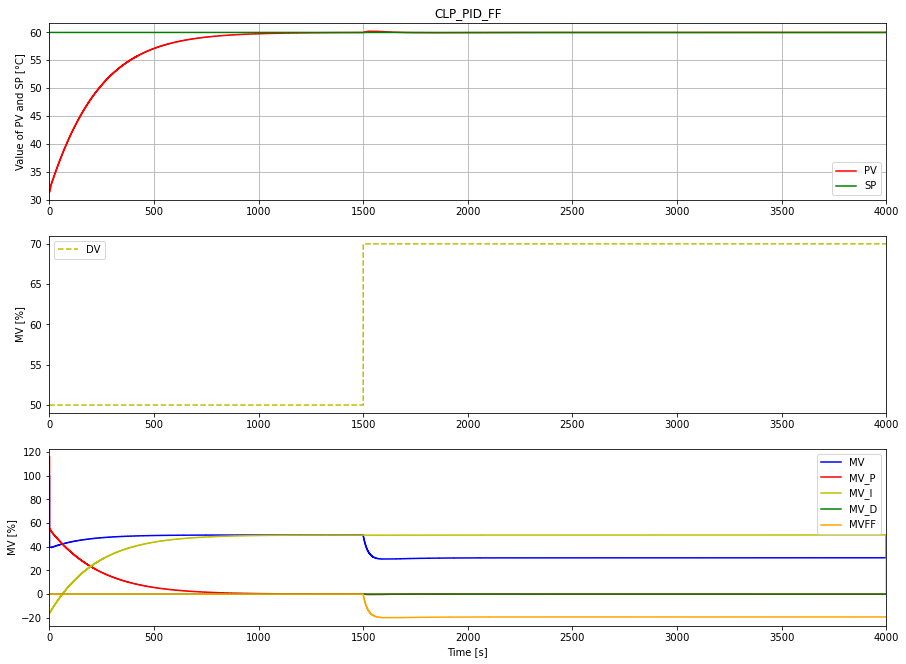

In [7]:
plt.figure(figsize = (15,15))
plt.subplot(4,1,1)
plt.title('CLP_PID_FF')
plt.step(t,PV,'r-', label = 'PV', where='post')
plt.step(t,SP,'g-', label = 'SP', where='post')
plt.grid()
plt.ylabel('Value of PV and SP [°C]')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(4,1,2)
plt.step(t,DV,'y--', label = 'DV', where='post')
plt.ylabel('MV [%]')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(4,1,3)
plt.step(t,MV,'b', label = 'MV', where='post')
plt.step(t,MV_P,'r-', label = 'MV_P', where='post')
plt.step(t,MV_I,'y-', label = 'MV_I', where='post')
plt.step(t,MV_D,'g-', label = 'MV_D', where='post')
plt.step(t,MV_FF,'orange', label = 'MVFF', where='post')
plt.ylabel('MV [%]')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, TSim])
